# Shoot rays with different units

### Author: M.Ravasi

This notebook compares raytracing in m and dm units (should give the same t)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.optimize import least_squares
from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.optimization.leastsquares import *

from refrtomo.invert import *
from refrtomo.raytrace import raytrace
from refrtomo.survey import *
from refrtomo.tomomatrix import *

## Velocity model

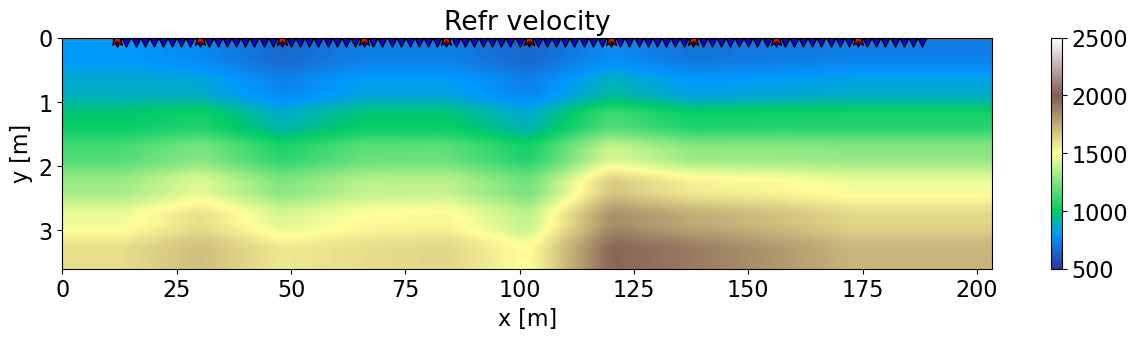

In [2]:
# Velocity model
fvel = np.load('../data/VelRefractionStryde.npz')
ftrav =  np.load('../data/FirstArrivalTravStryde.npz')

sc = 10. # from m to dm
x, z = fvel['x'], fvel['z'][:7]
nx, nz = x.size, z.size
dx, dz = x[1]-x[0], z[1]-z[0]
vel_refr = fvel['vel'][:, :7]
tobs = ftrav['tfirst']

# Pad model to last receiver
nxpad = (20, 50)
nx = nx + np.sum(nxpad)
x = np.arange(nx) * dx
vel_refr = np.pad(vel_refr, (nxpad, (0, 0)), mode='edge')

# Receivers
rx = ftrav['xr'] + nxpad[0] * dx
nr = rx.size
rz = 0*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
sx = ftrav['xs'] + nxpad[0] * dx
ns = sx.size
sz = 0*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(15,3))
im = plt.imshow(vel_refr.T , cmap='terrain', vmin=500, vmax=2500, 
                extent=(x[0] , x[-1] , z[-1] , z[0] ))
plt.scatter(recs[0] , recs[1] , marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0] , sources[1] , marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Refr velocity')
plt.ylim(z[-1] , z[0] );

## Original coordinates

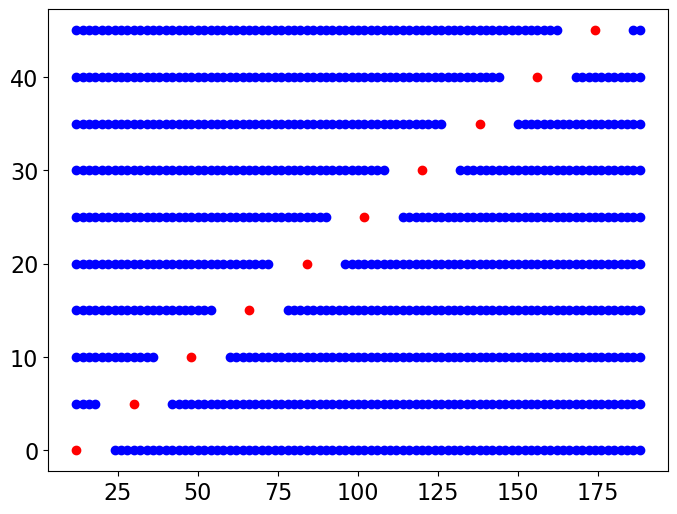

In [3]:
srcs = np.vstack((sx, sz))
recs = np.vstack((rx, rz))

survey = survey_geom(srcs, recs, minoffset=10)
display_survey(survey)

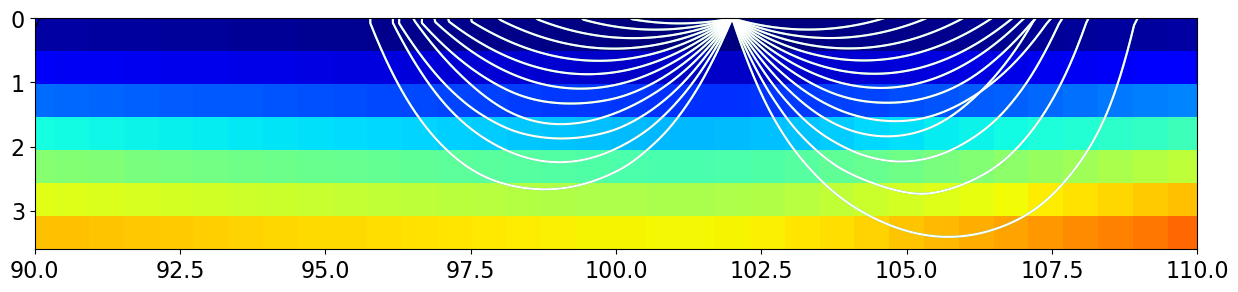

In [4]:
# Trace one source rays
lmax = 1e2
nl = 2000
thetas = np.hstack([np.arange(-80, -20, 5), np.arange(20, 80, 5)])

# Raytrace
rays, rays_turning, thetas_turning = raytrace(vel_refr.T, x, z, dx, dz, 
                                              lmax, nl, survey[ns//2].src, 
                                              thetas, dzout=1.)
tobs = [ray[-1, -1] for ray in rays]

plt.figure(figsize=(15, 3))
plt.imshow(vel_refr.T, cmap='jet', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(survey[ns//2].rec[0], survey[ns//2].rec[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(survey[ns//2].src[0], survey[ns//2].src[1], marker='*', s=150, c='r', edgecolors='k')
for ray in rays:
    plt.plot(ray[:,0], ray[:,1], '#3FB97E')
for ray in rays_turning:
    plt.plot(ray[:,0], ray[:,1], 'w')
plt.axis('tight')
plt.xlim(90, 110);

## Other coordinates

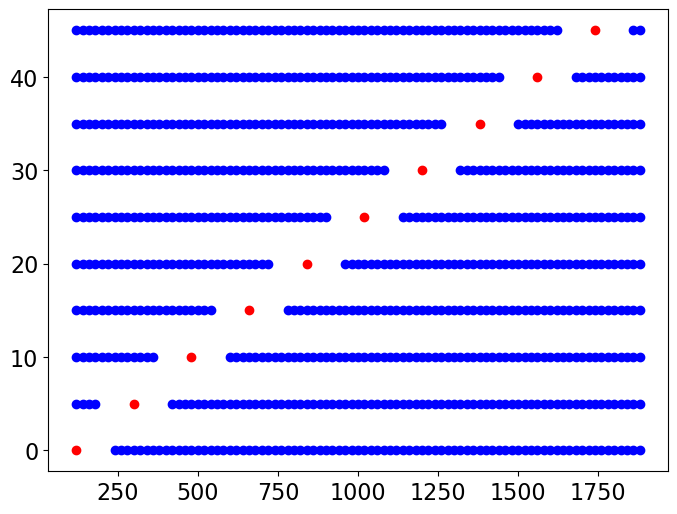

In [5]:
srcs = np.vstack((sx * sc, sz))
recs = np.vstack((rx * sc, rz))

survey = survey_geom(srcs, recs, minoffset=10 * sc)
display_survey(survey)

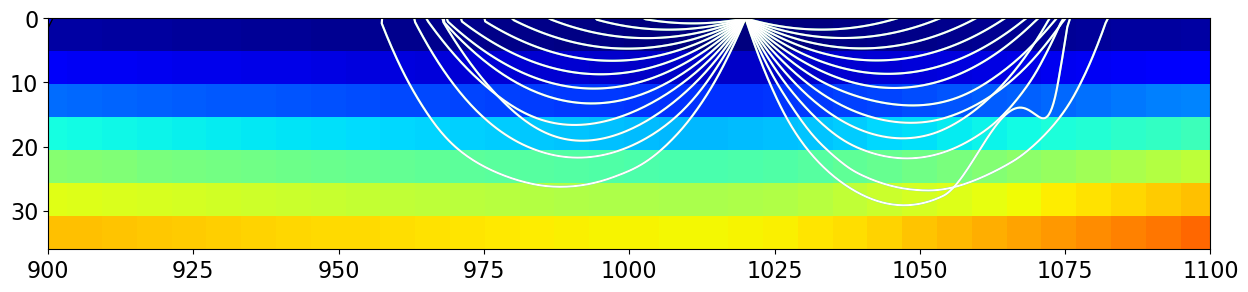

In [6]:
# Trace one source rays
lmax = 1e2 * sc
nl = 2000
thetas = np.hstack([np.arange(-80, -20, 5), np.arange(20, 80, 5)])

# Raytrace
rays1, rays1_turning, thetas1_turning = raytrace(vel_refr.T * sc, x * sc, z  * sc, dx * sc, dz * sc, 
                                                 lmax, nl, survey[ns//2].src, 
                                                 thetas, dzout=1. * sc)
tobs1 = [ray[-1, -1] for ray in rays1]

plt.figure(figsize=(15, 3))
plt.imshow(vel_refr.T, cmap='jet', extent = (x[0] * sc, x[-1] * sc, z[-1] * sc, z[0] * sc))
plt.scatter(survey[ns//2].rec[0], survey[ns//2].rec[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(survey[ns//2].src[0], survey[ns//2].src[1], marker='*', s=150, c='r', edgecolors='k')
for ray in rays1:
    plt.plot(ray[:,0], ray[:,1], '#3FB97E')
for ray in rays1_turning:
    plt.plot(ray[:,0], ray[:,1], 'w')
plt.axis('tight')
plt.xlim(90 * sc, 110 * sc);

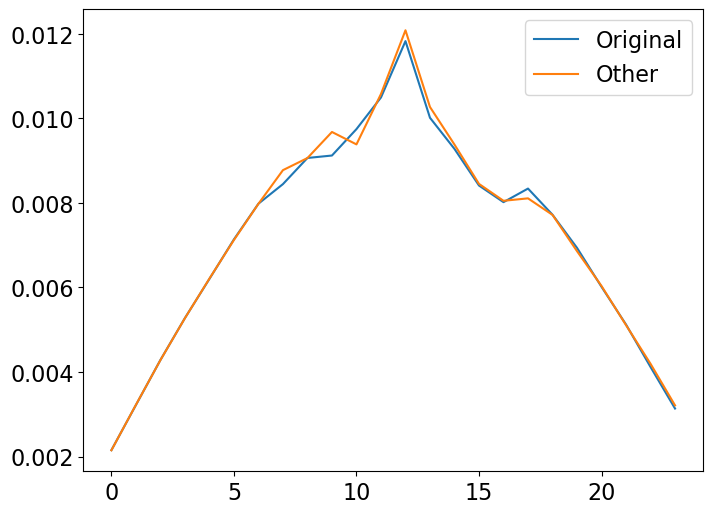

In [7]:
plt.figure()
plt.plot(tobs, label='Original')
plt.plot(tobs1, label='Other')
plt.legend();